In [54]:
from PIL import Image, ImageDraw
import numpy as np
import random
import os.path
import pickle

##############################################################################
#                        Functions for you to complete                       #
##############################################################################

def ComputeSSD(TODOPatch, TODOMask, textureIm, patchL):
	patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
	tex_rows, tex_cols, tex_bands = np.shape(textureIm)
	ssd_rows = tex_rows - 2 * patchL
	ssd_cols = tex_cols - 2 * patchL
	SSD = np.zeros((ssd_rows,ssd_cols))
	for r in range(ssd_rows):
		for c in range(ssd_cols):
			# Compute sum square difference between textureIm and TODOPatch
			# for all pixels where TODOMask = 0, and store the result in SSD
			#
			# ADD YOUR CODE HERE
			#
			textureIm.astype(np.float64)
			TODOPatch.astype(np.float64)
			red = np.sum(np.square(np.bitwise_and(textureIm[r:r+patch_rows,c:c+patch_cols,0] - TODOPatch[:,:,0], np.logical_not(TODOMask))))
			green = np.sum(np.square(np.bitwise_and(textureIm[r:r+patch_rows,c:c+patch_cols,1] - TODOPatch[:,:,1], np.logical_not(TODOMask))))
			blue = np.sum(np.square(np.bitwise_and(textureIm[r:r+patch_rows,c:c+patch_cols,2] - TODOPatch[:,:,2], np.logical_not(TODOMask))))
			SSD[r,c] = red + green + blue
			pass
		pass
	return SSD

def CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iMatchCenter,jMatchCenter,patchL):
	patchSize = 2 * patchL + 1	
	for i in range(patchSize):
		for j in range(patchSize):
			# Copy the selected patch selectPatch into the image containing
			# the hole imHole for each pixel where TODOMask = 1.
			# The patch is centred on iPatchCenter, jPatchCenter in the image imHole
			#
			# ADD YOUR CODE HERE
			#
			imHole[iPatchCenter-patchL+i,jPatchCenter-patchL+j,:] = textureIm[iMatchCenter-patchL+i,jMatchCenter-patchL+j,:] if TODOMask[i,j] else imHole[iPatchCenter-patchL+i,jPatchCenter-patchL+j,:]
			pass
		pass
	return imHole

##############################################################################
#                            Some helper functions                           #
##############################################################################

def DrawBox(im,x1,y1,x2,y2):
	draw = ImageDraw.Draw(im)
	draw.line((x1,y1,x1,y2),fill="white",width=1)
	draw.line((x1,y1,x2,y1),fill="white",width=1)
	draw.line((x2,y2,x1,y2),fill="white",width=1)
	draw.line((x2,y2,x2,y1),fill="white",width=1)
	del draw
	return im

def Find_Edge(hole_mask):
	[cols, rows] = np.shape(hole_mask)
	edge_mask = np.zeros(np.shape(hole_mask))
	for y in range(rows):
		for x in range(cols):
			if (hole_mask[x,y] == 1):
				if (hole_mask[x-1,y] == 0 or
						hole_mask[x+1,y] == 0 or
						hole_mask[x,y-1] == 0 or
						hole_mask[x,y+1] == 0):
					edge_mask[x,y] = 1
	return edge_mask

##############################################################################
#                           Main script starts here                          #
##############################################################################
def main_script(fileName, patchL=10, randomPatchSD=1): 
	#
	# Constants
	#

	# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
	# patchL = 10
	patchSize = 2*patchL+1

	# Standard deviation for random patch selection
	# randomPatchSD = 1

	# Display results interactively
	showResults = False

	#
	# Read input image
	#

	im = Image.open(fileName).convert('RGB')
	im_array = np.asarray(im, dtype=np.uint8)
	imRows, imCols, imBands = np.shape(im_array)

	#
	# Define hole and texture regions.  This will use files fill_region.pkl and
	#   texture_region.pkl, if both exist, otherwise user has to select the regions.
	if os.path.isfile('fill_region.pkl') and os.path.isfile('texture_region.pkl'):
		fill_region_file = open('fill_region.pkl', 'rb')
		fillRegion = pickle.load( fill_region_file )
		fill_region_file.close()

		texture_region_file = open('texture_region.pkl', 'rb')
		textureRegion = pickle.load( texture_region_file )
		texture_region_file.close()
	else:
		# ask the user to define the regions
		print("Specify the fill and texture regions using polyselect.py")
		exit()

	#
	# Get coordinates for hole and texture regions
	#

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])                # number of pixels to be filled
	iFillMax = max(fill_indices[0])
	iFillMin = min(fill_indices[0])
	jFillMax = max(fill_indices[1])
	jFillMin = min(fill_indices[1])
	assert((iFillMin >= patchL) and
			(iFillMax < imRows - patchL) and
			(jFillMin >= patchL) and
			(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

	texture_indices = textureRegion.nonzero()
	iTextureMax = max(texture_indices[0])
	iTextureMin = min(texture_indices[0])
	jTextureMax = max(texture_indices[1])
	jTextureMin = min(texture_indices[1])
	textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
	texImRows, texImCols, texImBands = np.shape(textureIm)
	assert((texImRows > patchSize) and
			(texImCols > patchSize)) , "Texture image is smaller than patch size"

	#
	# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
	#

	imHole = im_array.copy()
	imHole[fill_indices] = 0

	#
	# Is the user happy with fillRegion and textureIm?
	#
	if showResults == True:
		# original
		im.show()
		# convert to a PIL image, show fillRegion and draw a box around textureIm
		im1 = Image.fromarray(imHole).convert('RGB')
		im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
		im1.show()
		print("Are you happy with this choice of fillRegion and textureIm?")
		Yes_or_No = False
		while not Yes_or_No:
			answer = input("Yes or No: ")
			if answer == "Yes" or answer == "No":
				Yes_or_No = True
		assert answer == "Yes", "You must be happy. Please try again."

	#
	# Perform the hole filling
	#

	while (nFill > 0):
		print("Number of pixels remaining = " , nFill)

		# Set TODORegion to pixels on the boundary of the current fillRegion
		TODORegion = Find_Edge(fillRegion)
		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

		while(nTODO > 0):

			# Pick a random pixel from the TODORegion
			index = np.random.randint(0,nTODO)
			iPatchCenter = edge_pixels[0][index]
			jPatchCenter = edge_pixels[1][index]

			# Define the coordinates for the TODOPatch
			TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
			TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

			#
			# Compute masked SSD of TODOPatch and textureIm
			#
			ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

			# Randomized selection of one of the best texture patches
			ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
			ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
			ssdIndex = np.nonzero(ssdIm==ssdValue)
			iSelectCenter = ssdIndex[0][0]
			jSelectCenter = ssdIndex[1][0]

			# adjust i, j coordinates relative to textureIm
			iSelectCenter = iSelectCenter + patchL
			jSelectCenter = jSelectCenter + patchL
			selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

			#
			# Copy patch into hole
			#
			imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

			# Update TODORegion and fillRegion by removing locations that overlapped the patch
			TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
			fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

			edge_pixels = TODORegion.nonzero()
			nTODO = len(edge_pixels[0])

		fill_indices = fillRegion.nonzero()
		nFill = len(fill_indices[0])

	#
	# Output results
	#
	if showResults == True:
		Image.fromarray(imHole).convert('RGB').show()
	Image.fromarray(imHole).convert('RGB').save(fileName.replace('.jpg','-results.jpg'))



Number of pixels remaining =  3473
Number of pixels remaining =  1043
Number of pixels remaining =  53


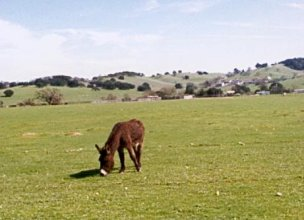

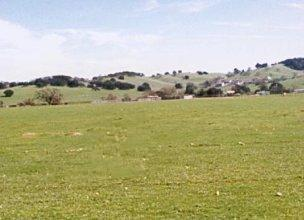

In [55]:
main_script("donkey.jpg")
display(Image.open("donkey.jpg"))
display(Image.open("donkey-results.jpg"))

Number of pixels remaining =  4172
Number of pixels remaining =  1844
Number of pixels remaining =  322


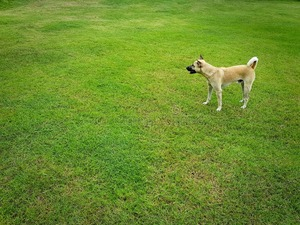

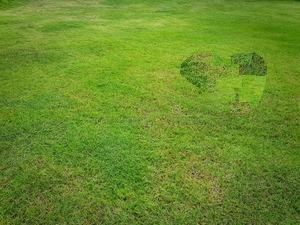

In [18]:
main_script("dog.jpg")
display(Image.open("dog.jpg"))
display(Image.open("dog-results.jpg"))
# The grass in the background is quite difficult for the algorithm. There are simply too much variables to consider for SSD to work well. The grass pixels get higher and higher in frequency higher up in the image. There are bright and dark patches of grass. Different shades of green and yellow are present. Given that the algorithm starts from the edges then goes inwards, the patches that match a portion of the rim may not match another portion of the rim, resulting in colour and brightness gaps when those sections join. 

Number of pixels remaining =  3072
Number of pixels remaining =  931


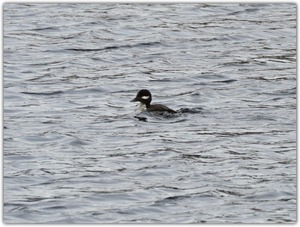

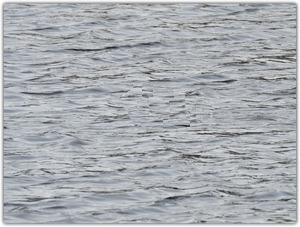

In [20]:
main_script("ducks.jpg")
display(Image.open("ducks.jpg"))
display(Image.open("ducks-results.jpg"))
# In this case, the algorithm performs pretty well at replacing the duck. Similar to the grass in the donkey image, waves benefit from the slight randomization of the algorithm, and have the benefit of the artifacts being less noticable as they are overshadowed by the sheer amount of different texons from the waves/water. 

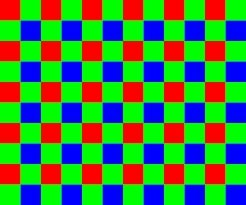

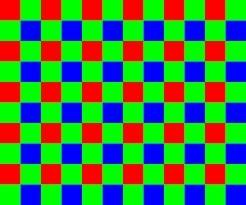

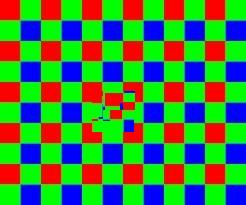

In [39]:
# RandomPatchSD for greater randomization in the selection of the best texture patch. 
# If this value is too small, for larger fills, there will be a lot of repetition in the texture.
# If this value is too large, the texture patch will be very different from the best match and the texture will look noisy or unexpected. 
display(Image.open("bayer.jpg"))
main_script("bayer.jpg", randomPatchSD=0.1)
display(Image.open("bayer-results.jpg"))
main_script("bayer.jpg", randomPatchSD=10)
display(Image.open("bayer-results.jpg"))
# In this example, I run the algorithm on a blue square. With a low randomPatchSD, it matches the blue square with the multitude of other very similar blue squares in the image and fills the square in with those. This is great for consistent textures. For something like water waves, where randomization is beneficial, a higher randomPatchSD is better.
# With a high randomPatchSD, the pool of possible texture patches is much larger and the algorithm is able to choose a texture patch that is not blue and fills the square in with that.

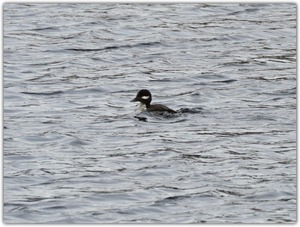

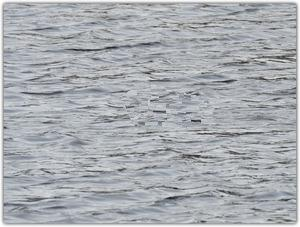

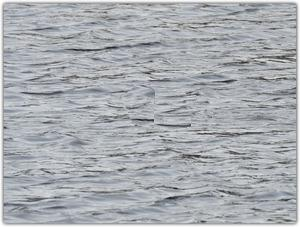

In [30]:
# patchL is proportional to the size of the texture patch that the SSD and other computations are performed on.
# If this value is too small, the texture patch will be too small to capture the texture of the texture image. For instance, if the texture is a poka dot pattern,  only quarter of a circle is captured in a patch, the synthesized texture may be a repeating pattern of quarter of a circle rather than full circles. 
# If this value is too large, given that we do not have a Gaussian weight for local structure, samples far from p will be considered in the computation of the SSD. This can result in noisy/unexpected results. 
display(Image.open("ducks.jpg"))
main_script("ducks.jpg", patchL=6)
display(Image.open("ducks-results.jpg"))
main_script("ducks.jpg", patchL=20)
display(Image.open("ducks-results.jpg"))
# In the first duck texture synthesis, you can see that the 'horizontal' lines generated by the waves are not fully captured by the patch, resulting in a lot of 'short' waves in the texture synthesis. This can potentially be resolved by copying just the center pixel as suggested by original Efros and Leung paper. 
# In the second duck texture synthesis, while longer waves are captured, they don't quite line up with the existing waves surrounding the duck. 
# Therefore the more optimal value of 10 gets less noticeable artifacts.